In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Subset
from tqdm import tqdm

transform = transforms.Compose([
    transforms.ToTensor(),           # Convert PIL image to tensor
    transforms.Normalize((0.,), (0.5,))  # Normalize grayscale values to [-1, 1] if desired
])

mnist_train = MNIST(root='./data', train=True, transform=transform, download=True)

# mnist_train = Subset(mnist_train, torch.where(mnist_train.targets == 9)[0])

train_loader = DataLoader(
    mnist_train,
    batch_size=64,
    shuffle=True
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Train loader=", len(train_loader), "Device=", device)


Train loader= 938 Device= cuda


In [5]:
T = 1000  # total timesteps
betas = torch.linspace(1e-4, 0.02, T)  # example linear schedule
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is BCHW
        diffY = x2.size()[-1] - x1.size()[-1]
        diffX = x1.size()[-2] - x1.size()[-2]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class EmbeddedFC(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.Linear(out_dim, out_dim)
        )
    
    def forward(self, t):
        t_embed = self.fc(t)
        return t_embed

class UNet(nn.Module):
    def __init__(self, n_channels=3):
        super().__init__()
        self.n_channels = n_channels
        
        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        
        self.up1 = (Up(256, 128))
        self.up2 = (Up(128, 64))
        self.outc = nn.Sequential(
            nn.Conv2d(64, n_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )
        
        self.t_embed1 = EmbeddedFC(1, 256)
        self.t_embed2 = EmbeddedFC(1, 128)
        
        self.c_embed1 = EmbeddedFC(10, 256)
        self.c_embed2 = EmbeddedFC(10, 128)
        
    def forward(self, x, t, c):
        # x=[B,n_channel,H,W]
        # t=[B,1]
        
        x1 = self.inc(x) # out=[B, 64, H, W]
        x2 = self.down1(x1) # out=[B, 128, H/2, W/2]
        x3 = self.down2(x2) # out=[B, 256, H/4, W/4]
        
        t1 = self.t_embed1(t) # out=[B, 256]
        t1 = t1.view(-1, 256, 1, 1).expand(-1, 256, x3.shape[-2], x3.shape[-1]) # out=[B, 256, H/4, W/4]
        c = F.one_hot(c, num_classes=10).type(torch.float) # [B, 10]
        c1 = self.c_embed1(c) # out=[B, 256]
        c1 = c1.view(-1, 256, 1, 1).expand(-1, 256, x3.shape[-2], x3.shape[-1]) # out=[B, 256, H/4, W/4]
        x = self.up1(x3 * c1 + t1, x2) # out=[B, 128, H/2, W/2]

        t2 = self.t_embed2(t) # out=[B, 128]
        t2 = t2.view(-1, 128, 1, 1).expand(-1, 128, x.shape[-2], x.shape[-1]) # out=[B, 128, H/2, W/2]
        c2 = self.c_embed2(c) # out=[B, 128]
        c2 = c2.view(-1, 128, 1, 1).expand(-1, 128, x.shape[-2], x.shape[-1]) # out=[B, 256, H/4, W/4]
        x = self.up2(x * c2 + t2, x1) # out=[B, 64, H, W]
        logits = self.outc(x) # out=[B, n_channel, H, W]
        return logits


In [7]:
import torch.optim as optim

model = UNet(n_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()


In [8]:
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0
    for batch_idx, (x0, c) in enumerate(train_loader):
        x0 = x0.to(device)  # shape [B, 1, 28, 28]
        c = c.to(device) # shape [B, 1]

        # Sample random timestep for each image in the batch
        t = torch.randint(0, T, (x0.size(0),), device=device).long()

        # Compute corresponding alpha cumulative product for each t
        alpha_bar_t = alphas_cumprod[t].to(device).view(-1, 1, 1, 1)

        # Sample noise
        noise = torch.randn_like(x0)

        # Create noisy image x_t
        x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise

        # Predict noise using model
        # Normalize timestep to a range or use embedding directly
        t_normalized = t.unsqueeze(-1).float() / T

        pred_noise = model(x_t, t_normalized, c)
        
        # Compute loss
        loss = mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Memory={torch.cuda.memory_allocated() / 1024 ** 3:.2f} GB")
    print(f"Epoch {epoch}: Loss {running_loss}")

Memory=0.05 GB
Epoch 0: Loss 248.2070407010615
Memory=0.05 GB
Epoch 1: Loss 36.28645304776728
Memory=0.05 GB
Epoch 2: Loss 31.222939593717456
Memory=0.05 GB
Epoch 3: Loss 28.931322995573282
Memory=0.05 GB
Epoch 4: Loss 26.904600001871586
Memory=0.05 GB
Epoch 5: Loss 26.376149348914623
Memory=0.05 GB
Epoch 6: Loss 25.813807922415435
Memory=0.05 GB
Epoch 7: Loss 25.24616897571832
Memory=0.05 GB
Epoch 8: Loss 24.80506594479084
Memory=0.05 GB
Epoch 9: Loss 24.43810284975916
Memory=0.05 GB
Epoch 10: Loss 24.29360416624695
Memory=0.05 GB
Epoch 11: Loss 23.87360603362322
Memory=0.05 GB
Epoch 12: Loss 24.0060049071908
Memory=0.05 GB
Epoch 13: Loss 23.743018369190395
Memory=0.05 GB
Epoch 14: Loss 23.124613048508763
Memory=0.05 GB
Epoch 15: Loss 23.207174811512232
Memory=0.05 GB
Epoch 16: Loss 22.87554462440312
Memory=0.05 GB
Epoch 17: Loss 22.97778462525457
Memory=0.05 GB
Epoch 18: Loss 22.82910768315196
Memory=0.05 GB
Epoch 19: Loss 22.746076888404787


In [14]:
@torch.no_grad()
def sample(model, T, shape, number_used_as_condition_embedding = 3):
    model.eval()
    x = torch.randn(shape, device=device)  # start from pure noise
    for t in reversed(range(T)):
        # Create tensor for current timestep
        t_tensor = torch.full((shape[0], 1), t, device=device).float() / T
        c = torch.tensor([number_used_as_condition_embedding]).type(torch.int64).to(device)
        # Predict noise
        pred_noise = model(x, t_tensor, c)
        # Compute coefficients
        alpha = alphas[t]
        alpha_bar = alphas_cumprod[t]
        alpha_bar_prev = alphas_cumprod[t - 1]
        beta = betas[t]

        # Predict the previous step x_{t-1}
        # Simplified update for demonstration; actual update may require more careful implementation
        x = (1/torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_bar)) * pred_noise)
        # Optionally add noise if t > 0
        if t > 0:
            noise = torch.randn_like(x)
            sigma = 1.05 * torch.sqrt(beta) * (1. - alpha_bar_prev) /  (1. - alpha_bar)
            x += 0.9 * sigma * noise

    return x

# Generate new samples
NUMBER_TO_GENERATE = 9
samples = sample(model, T, shape=(16, 1, 28, 28), number_used_as_condition_embedding = NUMBER_TO_GENERATE).cpu().numpy()

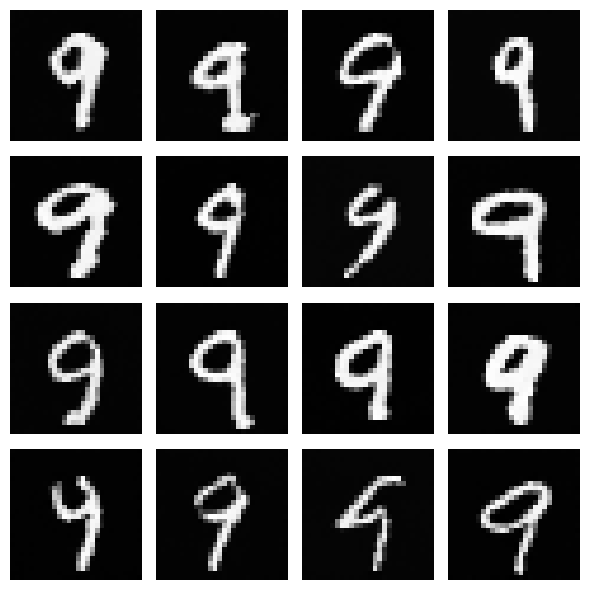

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    # Each sample is shape [1, 28, 28], so we take the first channel
    img = samples[i][0]  
    # Rescale the image values from normalization range if needed (e.g., from [-1,1] to [0,1])
    img = (img + 1) / 2  
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()